In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
using LinearAlgebra, Plots
import ForwardDiff as FD
using Printf
using JLD2

  Activating project at `~/Disk/2025FirstSemester/OptimalControl/LAB/HW1_S25`


# Q3 (31 pts): Log-Domain Interior Point Quadratic Program Solver

Here we are going to use the log-domain interior point method described in Lecture 5 to create a QP solver for the following general problem:

$$\begin{align}
\min_x \quad & \frac{1}{2}x^TQx + q^Tx \\ 
\text{s.t.}\quad &  Ax -b = 0 \\ 
&  Gx - h \geq 0 
\end{align}$$
where the cost function is described by $Q \in \mathbb{R}^{n \times n}$, $q \in \mathbb{R}^n$, an equality constraint is described by $A \in \mathbb{R}^{m \times n}$ and $b \in \mathbb{R}^m$, and an inequality constraint is described by $G \in \mathbb{R}^{p \times n}$ and $h \in \mathbb{R}^p$.

We'll first walk you through the steps to reformulate the problem into an interior point log-domain form that we can solve.

## Part (A): KKT Conditions (2 pts)
To reduce ambiguity (and make sure the test cases pass) for the KKT conditions, make sure that the stationarity condition term for the equality constraint is ($ + A^T\mu$) (not minus). The sign on $G^T\lambda$ is determined by the condition $\lambda \geq 0$.


**TASK**: Introduce Lagrange multipliers $\mu$ for the equality constraint, and $\lambda$ for the inequality constraint and fill in the following for the KKT conditions for the QP above. For complementarity use the $\circ$ symbol (i.e. $a \circ b = 0$).

Your KKT conditions should be in terms of problem data ($Q, q, A, b, G, h$) and decision variables ($x, \mu \text{ and } \lambda$)

$$\begin{align}
Qx+q+A^{T}\mu+G^{T}\lambda = 0 \quad \quad \text{(stationarity)} \\
Ax-b = 0 \quad \quad \text{(primal feasibility)} \\
Gx-h\geq 0 \quad \quad \text{(primal feasibility)} \\
\lambda \geq 0 \quad \quad \text{(dual feasibility)} \\
\lambda^{T}(Gx-h)= 0 \quad \quad \text{(complementarity)} 
\end{align}$$

## Part (B): Relaxed Complementarity (2 pts)

In order to apply the log-domain trick, we can introduce a slack variable to represent our inequality constraints ($s$). This new variable lets us enforce the inequality constraint ($s \geq 0$) by using a log-domain substitution which is always positive by construction. 

We'll also relax the complementarity condition as shown in class.

**TASK**: Modify the primal feasibility and complementarity by doing the following
1. Modify the primal feasiblity condition for the inequalities by adding a slack variable to split it into $Gx - h \geq 0$ condition into $Gx - h = s$ and $s \geq 0$ (there are now two conditions)
2. Relax the complementarity condition so $\lambda \circ s = 0$ becomes $\lambda \circ s = 1^T\rho$ where $\rho$ will be some positive barrier parameter and $1$ is a vector of ones.

The rest of the KKT conditions should remain the same. Write down the KKT conditions (there should now be six) after you've done the above steps.

The decision variables are now $x, \mu, \lambda\text{ and }s$. $\rho$ is the barrier parameter, which is a hyperparameter that will be set by your solver (not a decision variable).

$$\begin{align}
1. Qx + q + A^T\mu + G^T\lambda = 0  （stationarity）\\
2. Ax - b = 0  （primal \quad feasibility） \\
3. Gx - h = s  （primal \quad feasibility）\\
4. s \ge 0  （primal \quad feasibility）\\
5. \lambda \ge 0  （dual \quad feasibility）\\
6. \lambda \circ s = 1^{T}\rho  （relaxed \quad complementarity）
\end{align}$$

## Part (C): Log-domain Substitution (2 pts)

Finally, to enforce positivity on both $\lambda$ and $s$, we can perform a variable substitution. By using a particular substitution $\lambda = \sqrt\rho e^{-\sigma}$ and $s = \sqrt\rho e^\sigma$ we can also make sure that our relaxed complementarity condition $\lambda \circ s = 1^T\rho$ is always satisfied. 

**TASK**: Finally do the following:
1. Define a new variable $\sigma$ and define $\lambda = \sqrt\rho e^{-\sigma}$ and $s = \sqrt\rho e^\sigma$. 
2. Replace $\lambda$ and $s$ in your KKT conditions with the new definitions

After the steps above, the decision variables in your KKT conditions should be $x, \mu,\text{ and }\sigma$. QP solvers work by finding values for the decision variables that satisfy the KKT conditions if they exist.

With these new 6 KKT conditions, three of them are now always true for any value of $x, \mu\text{ and }\sigma$, meaning our solver doesn't need to consider them (think about properties of exponentials). Eliminate those 3 KKT conditions, leaving 3 conditions that are all equalities (can be written as $=0$). Since our final conditions are equalities, we can use a root-finding method (specifically Newton's method) to solve for our decision variables.

Write the remaing 3 KKT conditions below (hint: they should all be $=0$ and the only variables should be x, $\mu$, and $\sigma$).

1. **Stationarity（代入 λ）**

$$
Qx + q + A^T \mu + G^T\big(\sqrt{\rho}\, e^{-\sigma}\big) = 0
$$

2. **Primal feasibility – equality constraint**

$$
Ax - b = 0
$$

3. **Primal feasibility – inequality + slack（代入 s）**

$$
Gx - h - \sqrt{\rho}\, e^{\sigma} = 0
$$



## Part (D): Log-domain Interior Point Solver
We can now write our solver! You'll implement two residual functions (matching your residuals in Part A and C), and a function to solve the QP using Newton's method. The solver should work according to the following pseudocode where:
- $\rho$ is the barrier parameter
- kkt_conditions is the KKT conditions from part A
- ip_kkt_conditions is the KKT conditions from part C

```
rho = 0.1 (penalty parameter) 
for max_iters
    calculate the Newton step using ip_kkt_conditions and ip_kkt_jac
    perform a linesearch (use the same condition as in Q2, with the norm of the ip_kkt_conditions as the merit function)
    
    if norm(kkt_conditions, Inf) < tol
        return the solution
    else if norm(ip_kkt_conditions, Inf) < tol, update the barrier parameter
        rho = rho * 0.1
    end
end
```

In [2]:
# TODO: read below
# NOTE: DO NOT USE A WHILE LOOP ANYWHERE
"""
The data for the QP is stored in `qp` the following way:
    @load joinpath(@__DIR__, "qp_data.jld2") qp 

which is a NamedTuple, where
    Q, q, A, b, G, h, xi, μi, σi = qp.Q, qp.q, qp.A, qp.b, qp.G, qp.h

contains all of the problem data you will need for the QP.

Your job is to make the following functions where z = [x; μ; σ], λ = sqrt(ρ).*exp.(-σ), and s = sqrt(ρ).*exp.(σ)
    
    kkt_res = kkt_conditions(qp, z, ρ)
    ip_res = ip_kkt_conditions(qp, z)
    ip_jac = ip_kkt_jacobian(qp, z)
    x, μ, λ = solve_qp(qp; verbose = true, max_iters = 100, tol = 1e-8)

"""

# Helper functions (you can use or not use these)
function c_eq(qp::NamedTuple, x::Vector)::Vector
    qp.A*x - qp.b 
end
function h_ineq(qp::NamedTuple, x::Vector)::Vector
    qp.G*x - qp.h
end

"""
    kkt_res = kkt_conditions(qp, z, ρ)

Return the KKT residual from part A as a vector (make sure to clamp the inequalities!)
In Julia, use the following for elementwise min.
elementwise_min = min.(a, b) # This is elementwise min
scalar_elementwise_min = min.(a, 0) # You can also take an elementwise min with a scalar
"""
function kkt_conditions(qp::NamedTuple, z::Vector, ρ::Float64)::Vector
    x, μ, σ = z[qp.xi], z[qp.μi], z[qp.σi]

    # TODO compute λ from σ and ρ
    λ = sqrt(ρ) .* exp.(-σ)

    # TODO compute and return KKT conditions

    Q, q, A, b, G, h = qp.Q, qp.q, qp.A, qp.b, qp.G, qp.h

    # (1) stationarity: Qx + q + A'μ - G'λ = 0
    r_stat = Q * x + q + A' * μ - G' * λ

    # (2) primal feas (equality): Ax - b = 0
    r_eq = A * x - b

    # (3) primal feas (inequality): Gx - h ≥ 0  →  clamp 负的部分
    r_ineq = min.(G * x .- h, 0.0)

    # (4) dual feas: λ ≥ 0  →  clamp 负的部分
    r_dual = min.(λ, 0.0)

    # (5) complementarity: λ ∘ (Gx - h) = 0
    r_comp = λ .* (G * x .- h)

    # 拼成一个大 residual 向量
    return [r_stat; r_eq; r_ineq; r_dual; r_comp]
end

"""
    ip_res = ip_kkt_conditions(qp, z)

Return the interior point KKT residual from part C as a vector
"""
function ip_kkt_conditions(qp::NamedTuple, z::Vector, ρ::Float64)::Vector
    x, μ, σ = z[qp.xi], z[qp.μi], z[qp.σi]

    # TODO compute λ and s from σ and ρ
    λ = sqrt(ρ) .* exp.(-σ)
    s = sqrt(ρ) .* exp.(σ)
    # TODO compute and return IP KKT conditions
    Q, q, A, b, G, h = qp.Q, qp.q, qp.A, qp.b, qp.G, qp.h
    # (1) stationarity: Qx + q + A'μ - G'λ = 0
    r_stat = Q * x + q + A' * μ - G' * λ
    # (2) primal feas (equality): Ax - b = 0
    r_eq = A * x - b
    # (3) primal feas (inequality): Gx - h - s = 0
    r_ineq = G * x - h - s

    return [r_stat; r_eq; r_ineq]
end

"""
    ip_jac = ip_jacobian(qp, z, ρ)

Return the full Newton jacobian of the interior point KKT conditions (part C) with respect to z
Construct it analytically (don't use auto differentiation)
"""
function ip_kkt_jac(qp::NamedTuple, z::Vector, ρ::Float64)::Matrix
    x, μ, σ = z[qp.xi], z[qp.μi], z[qp.σi]

    # TODO: return full Newton jacobian (don't use ForwardDiff)
    # error("ip_kkt_jac not implemented")
    Q, q, A, b, G, h = qp.Q, qp.q, qp.A, qp.b, qp.G, qp.h

    # 先算 λ, s
    λ = sqrt(ρ) .* exp.(-σ)
    s = sqrt(ρ) .* exp.(σ)

    n = length(x)
    m = length(μ)
    p = length(σ)

    # 各个 block
    J11 = Q                          # n×n
    J12 = A'                         # n×m
    J13 = G' * Diagonal(λ)          # n×p

    J21 = A                          # m×n
    J22 = zeros(m, m)                # m×m
    J23 = zeros(m, p)                # m×p

    J31 = G                          # p×n
    J32 = zeros(p, m)                # p×m
    J33 = -Diagonal(s)               # p×p

    # 组装成 (n+m+p) × (n+m+p) 的雅可比
    top = [J11 J12 J13]
    mid = [J21 J22 J23]
    bot = [J31 J32 J33]

    return [top; mid; bot]
end

function logging(qp::NamedTuple, main_iter::Int, z::Vector, ρ::Real, α::Real)
    x, μ, σ = z[qp.xi], z[qp.μi], z[qp.σi]

    # TODO: compute λ
    λ = sqrt(ρ) .* exp.(-σ)

    # TODO: stationarity norm
    stationarity_norm = norm(qp.Q * x + qp.q + qp.A' * μ - qp.G' * λ, Inf)

    @printf("%3d  % 7.2e  % 7.2e  % 7.2e  % 7.2e  %5.0e  %5.0e\n",
          main_iter, stationarity_norm, minimum(h_ineq(qp,x)),
          norm(c_eq(qp,x),Inf), abs(dot(λ,h_ineq(qp,x))), ρ, α)
end

"""
    x, μ, λ = solve_qp(qp; verbose = true, max_iters = 100, tol = 1e-8)

Solve the QP using the method defined in the pseudocode above, where z = [x; μ; σ], λ = sqrt(ρ).*exp.(-σ), and s = sqrt(ρ).*exp.(σ)
"""
function solve_qp(qp; verbose = true, max_iters = 100, tol = 1e-8)
    # Init solution vector z = [x; μ; σ]
    z = zeros(length(qp.q) + length(qp.b) + length(qp.h))

    if verbose
        @printf "iter   |∇Lₓ|      min(h)       |c|       compl     ρ      α\n"
        @printf "----------------------------------------------------------------\n"
    end

    # TODO: implement your solver according to the above pseudocode
    ρ = 0.1   # penalty / barrier parameter

    for main_iter = 1:max_iters 

        # TODO: make sure to save the step length (α) from your linesearch for logging
        r_ip = ip_kkt_conditions(qp, z, ρ)
        J_ip = ip_kkt_jac(qp, z, ρ)

        # Solve for Newton step
        Δz = - (J_ip \ r_ip)
        old_norm = norm(r_ip, Inf)
        # Line search
        # my method
        # α = 1.0
        # for ls_iter = 1:10
        #     z_new = z + α * Δz
        #     r_new = ip_kkt_conditions(qp, z_new, ρ)
        #     if norm(r_new, Inf) < old_norm
        #         z .= z_new
        #         r_ip = r_new
        #         break
        #     end
        #     α *= 0.5
        # end

        # standard method
        α = 1.0
        for ls_iters = 1:10
            if norm(ip_kkt_conditions(qp, z + α * Δz, ρ)) < norm(r_ip)
                break
            end
            α = α / 2
        end

        z = z + α * Δz
        
        if verbose
            logging(qp, main_iter, z, ρ, α) 
        end

        # TODO: convergence criteria based on tol
        # SOLUTION
        if norm(kkt_conditions(qp, z, ρ), Inf) < tol
            x, μ, λ = z[qp.xi], z[qp.μi], sqrt(ρ) .* exp.(-z[qp.σi])
            return x, μ, λ
        elseif norm(ip_kkt_conditions(qp, z, ρ), Inf) < tol
            ρ = ρ * 0.1
        end
    end
    error("qp solver did not converge")
end

solve_qp

### QP Solver test

In [3]:
# 10 points 
using Test 
@testset "qp solver" begin 
    @load joinpath(@__DIR__, "qp_data.jld2") qp 
    x, λ, μ = solve_qp(qp; verbose = true, max_iters = 100, tol = 1e-6)
    
    @load joinpath(@__DIR__, "qp_solutions.jld2") qp_solutions
    @test norm(kkt_conditions(qp, qp_solutions.z, qp_solutions.ρ))<1e-3;
    @test norm(ip_kkt_conditions(qp, qp_solutions.z, qp_solutions.ρ))<1e-3;
    @test norm(ip_kkt_jac(qp, qp_solutions.z, qp_solutions.ρ) - FD.jacobian(dz -> ip_kkt_conditions(qp, dz, qp_solutions.ρ), qp_solutions.z), Inf) < 1e-3
    @test norm(x - qp_solutions.x,Inf)<1e-3;
    @test norm(λ - qp_solutions.λ,Inf)<1e-3;
    @test norm(μ - qp_solutions.μ,Inf)<1e-3;
end

iter   |∇Lₓ|      min(h)       |c|       compl     ρ      α
----------------------------------------------------------------
  1   4.32e+00  -3.51e-01   1.22e-15   6.94e-01  1e-01  1e+00
  2   8.86e-01   6.08e-02   2.22e-16   3.80e-01  1e-01  1e+00
  3   9.19e-02   8.52e-02   4.44e-16   4.52e-01  1e-01  1e+00
  4   2.79e-03   9.01e-02   0.00e+00   4.90e-01  1e-01  1e+00
  5   2.29e-04   9.03e-02   2.22e-16   4.99e-01  1e-01  1e+00
  6   6.36e-07   9.03e-02   4.44e-16   5.00e-01  1e-01  1e+00
  7   3.81e-12   9.03e-02   1.11e-16   5.00e-01  1e-01  1e+00
  8   4.43e-01   3.03e-02   8.88e-16   9.05e-02  1e-02  5e-01
  9   1.73e-02   9.16e-03   4.44e-16   4.93e-02  1e-02  1e+00
 10   9.53e-05   9.28e-03   2.22e-16   5.00e-02  1e-02  1e+00
 11   6.87e-09   9.28e-03   0.00e+00   5.00e-02  1e-02  1e+00
 12   2.31e-01   2.98e-03   1.78e-15   8.59e-03  1e-03  5e-01
 13   7.82e-03   9.35e-04   1.78e-15   4.93e-03  1e-03  1e+00
 14   1.24e-05   9.40e-04   8.88e-16   5.00e-03  1e-03  1e+00
 15   1

Test.DefaultTestSet("qp solver", Any[], 6, false, false, true, 1.765456481334681e9, 1.765456483743594e9, false, "/home/zks/Disk/2025FirstSemester/OptimalControl/LAB/HW1_S25/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X11sZmlsZQ==.jl")

# Simulating a Falling Brick with QPs
In this question we'll be simulating a brick falling and sliding on ice in 2D. You will show that this problem can be formulated as a QP, which you will solve using an Interior Point method.

## The Dynamics
The dynamics of the brick can be written in continuous time as
$$ M \dot{v}  + M g = J^T \mu \\ \text{ where } M = mI_{2\times 2}, \; g = \begin{bmatrix} 0 \\ 9.81 \end{bmatrix},\; J = \begin{bmatrix} 0 & 1 \end{bmatrix} $$
and $\mu \in \mathbb{R}$ is the normal force. The velocity $v \in \mathbb{R}^2$ and position $q \in \mathbb{R}^2$ are composed of the horizontal and vertical components.

We can discretize the dynamics with backward Euler:
$$ \begin{bmatrix} v_{k+1} \\ q_{k+1} \end{bmatrix} = \begin{bmatrix} v_k \\ q_k \end{bmatrix}
+ \Delta t \cdot \begin{bmatrix} \frac{1}{m} J^T \mu_{k+1} - g \\ v_{k+1} \end{bmatrix}$$

We also have the following contact constraints:
$$ \begin{align}
J q_{k+1} &\geq 0 &&\text{(don't fall through the ice)} \\
\mu_{k+1} &\geq 0 &&\text{(normal forces only push, not pull)} \\
\mu_{k+1} J q_{k+1} &= 0 &&\text{(no force at a distance)}
\end{align} $$

## Part (E): QP formulation for Falling Brick (5 pts)
Show that these discrete-time dynamics are equivalent to the following QP by writing down the KKT conditions.

$$ \begin{align}
    &\text{minimize}_{v_{k+1}} && \frac{1}{2} v_{k+1}^T M v_{k+1} + [M (\Delta t \cdot g - v_k)]^Tv_{k+1} \\
    &\text{subject to} && J(q_k + \Delta t \cdot v_{k+1}) \geq 0 \\
\end{align} $$

**TASK**: Write down the KKT conditions for the optimization problem above, and show that it's equivalent to the dynamics problem stated previously. Use LaTeX markdown.

**PUT ANSWER HERE:**

## Part (F): Brick Simulation (5 pts)

## 1. 原始动力学 + 接触约束

不考虑旋转时，砖块的竖直动力学可以写成（课件上那句）

$$
M \dot v + Mg = J^T \lambda
$$

* $v$：速度（这里只看竖直方向就行）
* $M$：质量矩阵
* $g$：重力加速度向量
* $J$：接触 Jacobian（把速度投影到地面法向）
* $\lambda \ge 0$：法向接触力

位置更新：

$$
q_{k+1} = q_k + h v_{k+1}
$$

接触约束写成不等式：

$$
J q_{k+1} \ge 0,\quad \lambda_{k+1} \ge 0,\quad 
\lambda_{k+1}^T J q_{k+1} = 0
$$

也就是：

* 砖块不能穿地：$J q_{k+1} \ge 0$
* 接触力向上推：$\lambda \ge 0$
* 有距离没力，有力必在地面上：互补性 $\lambda \circ Jq_{k+1} = 0$

---

## 2. 离散化：隐式欧拉得到“想要的自由落体速度”

用隐式欧拉离散上面的动力学：

$$
M \frac{v_{k+1} - v_k}{h} + Mg = J^T \lambda_{k+1}
$$

无接触力（$\lambda=0$) 的“自由落体速度”是：

$$
v^\star = v_k + h g
$$

如果没有地面，我们就用这个速度更新；
但有地面 → 我们不允许穿透，所以真正的 $v_{k+1}$ 不能任性取 $v^\star$。

于是我们做的事是：

> 在满足接触约束的前提下，让 $v_{k+1}$ 尽量接近自由落体速度 $v^\star$。

这就是 QP 的核心思想。

---

## 3. 为什么目标函数是

$\displaystyle \phi(v_{k+1})$ 这个奇怪的二次项？

给定自由落体速度 $v^\star = v_k + h g$，
我们想最小化的是**偏离自由运动的程度**：

$$
\min_{v_{k+1}} \frac12 \| v_{k+1} - v^\star \|_M^2
= \frac12 (v_{k+1} - v^\star)^T M (v_{k+1} - v^\star)
$$

展开这个式子：

$$
\frac12 v_{k+1}^T M v_{k+1}
- v_{k+1}^T M v^\star
+ \frac12 v^{\star T} M v^\star
$$

把 $v^\star = v_k + hg$ 代进去：

$$
\frac12 v_{k+1}^T M v_{k+1}
+ v_{k+1}^T M (hg - v_k)
+ \text{常数项}
$$

那一项“常数项”跟 $v_{k+1}$ 无关，对最小化没影响，扔掉就得到课件里的

$$
\phi(v_{k+1})
= \frac12 v_{k+1}^T M v_{k+1}
+ v_{k+1}^T M(hg - v_k)
$$

✅ 所以：

> **φ 的物理意义并不是“动能”，而是
> “离自由落体速度 $v^\star$ 的 M 加权平方距离”
> 即：找一个在约束下离 $v_k + h g$ 最近的速度。**

这是一个离散化之后的“最小作用量 / 最小残差”形式。

---

## 4. QP 的约束从哪来？

位置更新：

$$
q_{k+1} = q_k + h v_{k+1}
$$

接触约束是：

$$
J q_{k+1} \ge 0
\quad\Rightarrow\quad
J(q_k + h v_{k+1}) \ge 0
$$

再加上互补性和接触力非负（这会随后出现在 KKT 里）。

于是 QP 可以写成：

$$
\begin{aligned}
\min_{v_{k+1}} \quad & 
\phi(v_{k+1})
= \frac12 v_{k+1}^T M v_{k+1}
  + v_{k+1}^T M(hg - v_k) \\
\text{s.t.}\quad & J(q_k + h v_{k+1}) \ge 0
\end{aligned}
$$

这是一个**只对速度优化**的 QP，约束是“不穿透地面”。

---

## 5. 写拉格朗日函数并求 KKT 条件

给这个 QP 引入拉格朗日乘子 $\lambda \ge 0$（注意此时 λ 就是接触力）：

$$
L(v_{k+1}, \lambda)
= \phi(v_{k+1})
- \lambda^T \, J(q_k + h v_{k+1})
$$

（因为约束是 $J(q_k + h v_{k+1}) \ge 0$，
习惯是写成 “≥0” 对应 “−λ⋅约束”，这样 λ ≥ 0）

---

### 5.1 Stationarity（对 $v_{k+1}$ 求导）

先对 φ 求导：

$$
\nabla_{v_{k+1}} \phi
= M v_{k+1} + M(hg - v_k)
$$

对拉格朗日中的约束项：

$$
- \lambda^T J(q_k + h v_{k+1})
\quad \Rightarrow \quad
- h J^T \lambda
$$

令梯度为 0（stationarity）：

$$
M v_{k+1} + M(hg - v_k) - h J^T \lambda = 0
$$

整理一下：

$$
M (v_{k+1} - v_k) + Mh g = h J^T \lambda
$$

两边除以 h 就变成：

$$
M \frac{v_{k+1} - v_k}{h} + Mg = J^T \lambda
$$

✅ 这正是我们一开始写的**离散动力学方程**，说明：

> **KKT 的 stationarity 条件恰好给出力学方程。**

---

### 5.2 Primal feasibility（原始约束）

$$
J(q_k + h v_{k+1}) \ge 0
$$

这就是**不穿透**。

---

### 5.3 Dual feasibility（乘子非负）

$$
\lambda \ge 0
$$

这就是**接触力只能推不开，不能“拉地面”**。

---

### 5.4 Complementarity（互补性）

不等式约束的 KKT 还要满足：

$$
\lambda^T J(q_k + h v_{k+1}) = 0
$$

也就是：

* 若离地面有正距离（>0），则 λ 必须为 0；
* 若 λ > 0，则一定在地面上（距离 = 0）。

✅ 这就是我们物理里讲的**互补条件**。

---

## 6. 大结论：QP 的 KKT = 动力学 + 接触条件

我们现在得到的 KKT 系统正好是：

1. **动力学方程（Stationarity）**

   $$
   M \frac{v_{k+1} - v_k}{h} + Mg = J^T \lambda
   $$

2. **不穿透约束（Primal feasibility）**

   $$
   J(q_k + h v_{k+1}) \ge 0
   $$

3. **接触力向上（Dual feasibility）**

   $$
   \lambda \ge 0
   $$

4. **互补性（Complementarity）**

   $$
   \lambda^T J(q_k + h v_{k+1}) = 0
   $$

这四条就是你熟悉的**不等式约束 KKT 条件**，同时也就是**带碰撞/接触的刚体动力学方程 + 接触条件**。

所以：

> **每一步仿真：
> 就是解一个 QP：找一个在接触约束下离自由落体速度最近的速度 $v_{k+1}$。
> 这个 QP 的 KKT 条件，刚好就是你要的动力学 + 接触互补条件。**



In [4]:
function brick_simulation_qp(q, v; mass = 1.0, Δt = 0.01)
    
    # TODO: fill in the QP problem data for a simulation step 
    # fill in Q, q, G, h, but leave A, b the same 
    # this is because there are no equality constraints in this qp 
    # 重力
    g = [0.0, 9.81]
    # 质量矩阵
    M = mass * I(2)

    # 目标函数 ½ x'Qx + q'x
    Q = Matrix(M)
    q_vec = M * (Δt * g - v)

    # 不等式约束 Gx ≥ h  ： J(q + Δt v⁺) ≥ 0  ->  [0 Δt] v⁺ ≥ -qz
    G = [0.0 Δt]
    h = [0 -1] * q

    qp = (
        Q=Q,
        q=q_vec,
        A=zeros(0, 2),   # don't edit this
        b=zeros(0),
        G=G,
        h=h,
        xi=1:2,          # don't edit this
        μi=[],           # don't edit this
        σi=3:3           # don't edit this
    )
    return qp 
end

brick_simulation_qp (generic function with 1 method)

In [5]:
@testset "brick qp" begin 
    
    q = [1,3.0]
    v = [2,-3.0]
    
    qp = brick_simulation_qp(q,v)
    
    # check all the types to make sure they're right
    qp.Q::Matrix{Float64}
    qp.q::Vector{Float64}
    qp.A::Matrix{Float64}
    qp.b::Vector{Float64}
    qp.G::Matrix{Float64}
    qp.h::Vector{Float64}
    
    @test size(qp.Q) == (2,2)
    @test size(qp.q) == (2,)
    @test size(qp.A) == (0,2)
    @test size(qp.b) == (0,)
    @test size(qp.G) == (1,2)
    @test size(qp.h) == (1,)
    
    @test abs(tr(qp.Q) - 2) < 1e-10
    @test norm(qp.q - [-2.0, 3.0981]) < 1e-10 
    @test norm(qp.G - [0 .01]) < 1e-10 
    @test abs(qp.h[1] - -3) < 1e-10
    
end

Test Summary: | Pass  Total  Time
brick qp      |   10     10  0.1s


Test.DefaultTestSet("brick qp", Any[], 10, false, false, true, 1.765456484178424e9, 1.765456484319718e9, false, "/home/zks/Disk/2025FirstSemester/OptimalControl/LAB/HW1_S25/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X20sZmlsZQ==.jl")

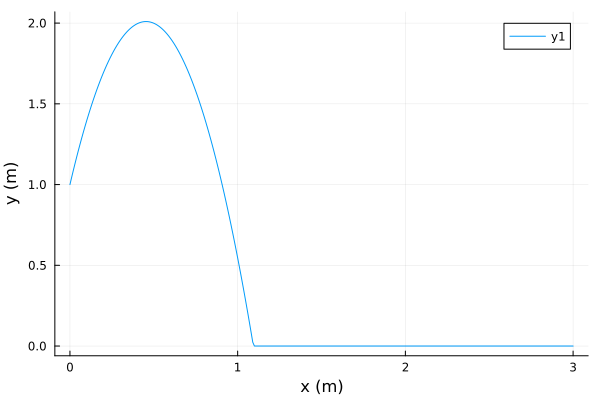

#= /home/zks/Disk/2025FirstSemester/OptimalControl/LAB/HW1_S25/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X21sZmlsZQ==.jl:28 =# @test(abs(maximum(ys) - 2) < 0.1) = Test Passed
#= /home/zks/Disk/2025FirstSemester/OptimalControl/LAB/HW1_S25/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X21sZmlsZQ==.jl:29 =# @test(minimum(ys) > -0.01) = Test Passed
#= /home/zks/Disk/2025FirstSemester/OptimalControl/LAB/HW1_S25/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X21sZmlsZQ==.jl:30 =# @test(abs(xs[end] - 3) < 0.01) = Test Passed
#= /home/zks/Disk/2025FirstSemester/OptimalControl/LAB/HW1_S25/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X21sZmlsZQ==.jl:33 =# @test(maximum(xdot) < 1.0001) = Test Passed
#= /home/zks/Disk/2025FirstSemester/OptimalControl/LAB/HW1_S25/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X21sZmlsZQ==.jl:34 =# @test(minimum(xdot) > 0.9999) = Test Passed
#= /home/zks/Disk/2025FirstSemester/OptimalControl/LAB/HW1_S25/jl_notebook_cell_df34fa98e69747e1a8f8a73

┌ Info: Listening on: 127.0.0.1:8705, thread id: 1
└ @ HTTP.Servers /home/zks/.julia/packages/HTTP/ShTJs/src/Servers.jl:382
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8705
└ @ MeshCat /home/zks/.julia/packages/MeshCat/4DqVC/src/visualizer.jl:39


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("brick" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x68, 0x63, 0x61, 0x74, 0x2f, 0x62, 0x72, 0x69, 0x63, 0x6b], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), Set{HTTP.WebSockets.WebSocket}(), ip"127.0.0.1", 8705, HTTP.Servers.Server{HTTP.Servers.Listener{Nothing, Sockets.TCPServer}}(HTTP.Servers.Listener{Nothing, Sockets.TCPServer}(Sockets.InetAddr{Sockets.IPv4}(ip"127.0.0.1", 8705), "127.0.0.1", "8705", nothing, Sockets.TCPServer(RawFD(27) active)), nothing, Set{HTTP.Connections.Connection}(), Task (runnable) @0x00007a6da223a400, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (1, 134611310517552, -4637377290965062433))), MeshCat.AnimationContext[]))

In [6]:
include(joinpath(@__DIR__, "animate_brick.jl"))
let 
    
    dt = 0.01 
    T = 3.0 
    
    t_vec = 0:dt:T
    N = length(t_vec)
    
    qs = [zeros(2) for i = 1:N]
    vs = [zeros(2) for i = 1:N]
    
    qs[1] = [0, 1.0]
    vs[1] = [1, 4.5]
    
    # TODO: simulate the brick by forming and solving a qp 
    # at each timestep. Your QP should solve for vs[k+1], and
    # you should use this to update qs[k+1]
    for k = 1:(N-1)
        qp = brick_simulation_qp(qs[k], vs[k])
        vs[k+1], _, _ = solve_qp(qp; verbose=false, tol=1e-4)
        qs[k+1] = qs[k] + dt * vs[k+1]
    end
    
    xs = [q[1] for q in qs]
    ys = [q[2] for q in qs]
    
    @show @test abs(maximum(ys)-2)<1e-1
    @show @test minimum(ys) > -1e-2
    @show @test abs(xs[end] - 3) < 1e-2
    
    xdot = diff(xs)/dt
    @show @test maximum(xdot) < 1.0001
    @show @test minimum(xdot) > 0.9999
    @show @test ys[110] > 1e-2
    @show @test abs(ys[111]) < 1e-2
    @show @test abs(ys[112]) < 1e-2
    
    display(plot(xs, ys, ylabel = "y (m)", xlabel = "x (m)"))
    
    animate_brick(qs)
    
    
    
end

# Part G (5 pts): Solve a QP

Use your QP solver to solve the following optimization problem:


$$
\begin{align} 
\min_{y\in\mathbb{R}^2,a\in\mathbb{R},b\in\mathbb{R}} \quad & \frac{1}{2}y^T \begin{bmatrix} 1 & .3 \\ .3 & 1 \end{bmatrix} y + a^2 + 2b^2  + \begin{bmatrix} -2 & 3.4 \end{bmatrix} y + 2a + 4b \\ 
\text{st} \quad & a + b = 1 \\ 
& \begin{bmatrix}-1 & 2.3 \end{bmatrix} y + a - 2b =3 \\
& -0.5 \leq y \leq 1 \\ 
& -1 \leq a \leq 1 \\ 
& -1 \leq b \leq 1
\end{align}
$$

You should be able to put this into our standard QP form that we used above, and solve.

In [7]:
@testset "part D" begin

    y = randn(2)
    a = randn()
    b = randn()
    
    #TODO: Create your qp and solve it. Don't forget the indices (xi, μi, and σi)
    
    # SOLUTIONS
    Q = [
        1.0 0.3 0 0;
        0.3 1.0 0 0;
        0 0 2 0;
        0 0 0 4
    ]

    q = [-2, 3.4, 2, 4]

    A = [
        0 0 1 1;
        -1 2.3 1 -2
    ]
    b = [
        1,
        3
    ]

    G = [-diagm(ones(4)); diagm(ones(4))]
    primal_max = [1, 1, 1, 1.]
    primal_min = [-0.5, -0.5, -1, -1]
    h = [-primal_max; primal_min]

    qp = (Q=Q, q=q, A=A, b=b, G=G, h=h, xi=1:4, μi=5:6, σi=7:14)

    x, _, _ = solve_qp(qp; verbose=true, tol=1e-6)

    y = x[1:2]
    a = x[3]
    b = x[4]
    
    @test norm(y - [-0.080823; 0.834424]) < 1e-3 
    @test abs(a - 1) < 1e-3 
    @test abs(b) < 1e-3 
end

iter   |∇Lₓ|      min(h)       |c|       compl     ρ      α
----------------------------------------------------------------
  1   3.07e+00   5.40e-01   2.25e+00   1.50e+00  1e-01  2e-01
  2   2.09e+00   1.12e-01   1.12e+00   1.16e+00  1e-01  5e-01
  3   2.52e+00  -2.86e-03   1.11e-16   5.75e-01  1e-01  1e+00
  4   2.87e-01   1.49e-02   0.00e+00   7.80e-01  1e-01  1e+00
  5   3.26e-03   1.58e-02   1.11e-16   7.99e-01  1e-01  1e+00
  6   1.13e-06   1.58e-02   4.44e-16   8.00e-01  1e-01  1e+00
  7   8.22e-13   1.58e-02   4.44e-16   8.00e-01  1e-01  1e+00
  8   1.32e+00   6.45e-03   4.44e-16   1.02e-01  1e-02  5e-01
  9   1.68e-01   1.67e-03   4.44e-16   7.94e-02  1e-02  1e+00
 10   2.40e-03   1.79e-03   4.44e-16   8.00e-02  1e-02  1e+00
 11   5.12e-07   1.79e-03   8.88e-16   8.00e-02  1e-02  1e+00
 12   4.82e-01   5.85e-04   0.00e+00   1.04e-02  1e-03  5e-01
 13   2.22e-02   1.80e-04   4.44e-16   7.98e-03  1e-03  1e+00
 14   4.44e-05   1.82e-04   4.44e-16   8.00e-03  1e-03  1e+00
 15   1

Test.DefaultTestSet("part D", Any[], 3, false, false, true, 1.765456487418372e9, 1.765456488210446e9, false, "/home/zks/Disk/2025FirstSemester/OptimalControl/LAB/HW1_S25/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X23sZmlsZQ==.jl")